In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as tick
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed, RepeatVector, Input

In [3]:
# define filepath to read data
dir_path = './Challenge_Data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test.txt'), sep='\s+', header=None, names=col_names)

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [4]:
rul_limit = 922337203
df = train
grouped_by_unit = df.groupby(by="unit_nr")
max_cycle = grouped_by_unit["time_cycles"].max()

# Merge the max cycle back into the original frame
result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

# Calculate remaining useful life for each row
remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])

In [5]:
def add_remaining_useful_life(df, rul_limit = 922337203):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])    
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train, 100)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,100
1,1,2,100
2,1,3,100
3,1,4,100
4,1,5,100


## Cluster-wise Standardization

In [6]:
from sklearn.preprocessing import StandardScaler
def create_clusters(df):
    model = pickle.load(open("kmeans_op.pkl", "rb"))
    preds = model.predict(df[['setting_1', 'setting_2', 'setting_3']])
    tmp = df.copy()
    tmp["op_cond"] = pd.Series(preds)
    tmp = tmp.drop(['setting_1', 'setting_2', 'setting_3'], axis=1)
    return tmp

def create_scalers(df, scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']): #should probably just give train split here
    
    scalers = []
    for i in range(6):
        scaler = StandardScaler()
        scaler.fit(df[df["op_cond"] == i][scaling_columns])
        scalers.append(scaler)
    
    return scalers

In [7]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [8]:
from sklearn.model_selection import GroupShuffleSplit
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, gss, groups, print_groups=True):
    y = X.pop('RUL')
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split
# train = create_clusters(train)
# split_result = train_val_group_split(train, gss, train['unit_nr'])
# X_train, y_train, X_val, y_val = split_result

In [9]:
def scale(df, scalers, sensor_names = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']):
    
    for condition in df['op_cond'].unique():
        scaler = scalers[condition]
        df.loc[df['op_cond']==condition, sensor_names] = scaler.transform(df.loc[df['op_cond']==condition, sensor_names])
    
    return df

In [10]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

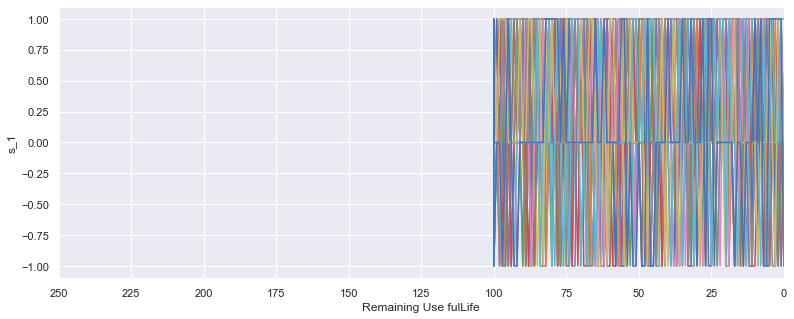

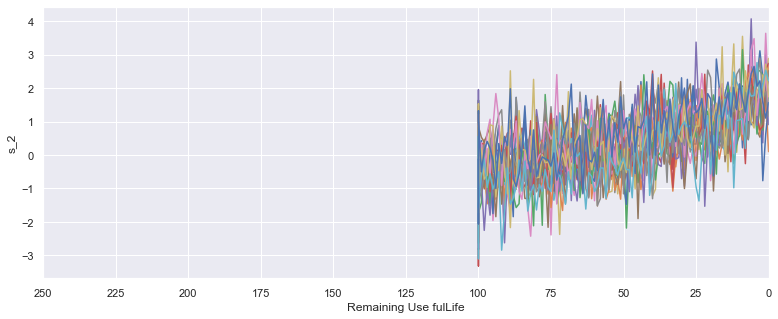

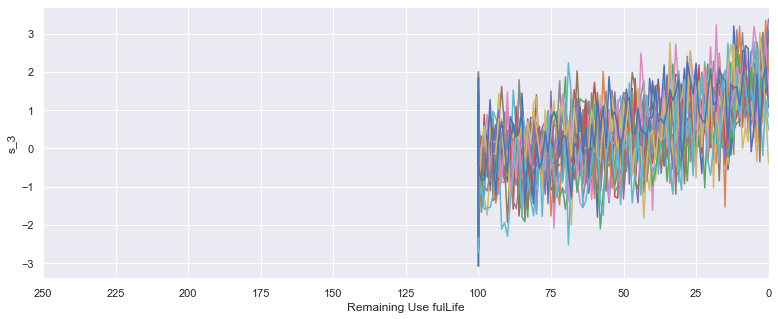

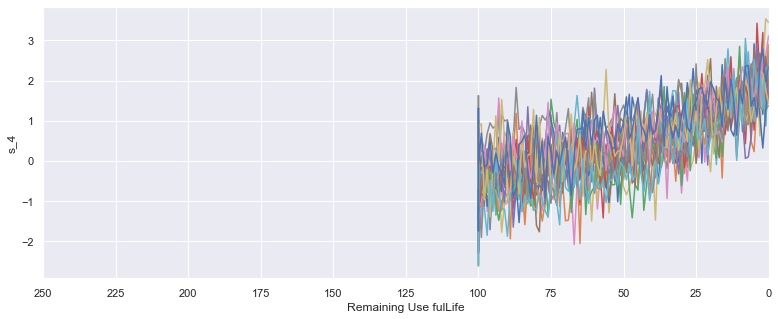

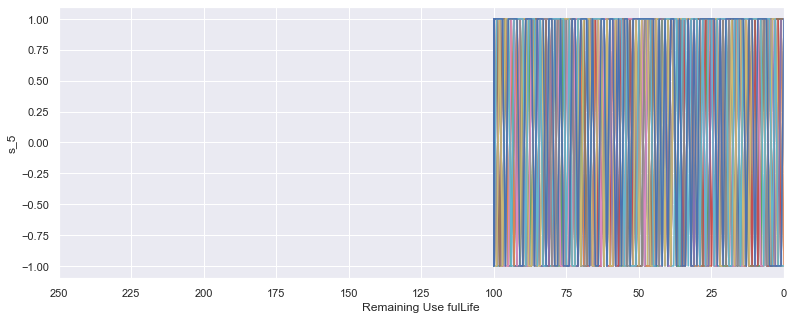

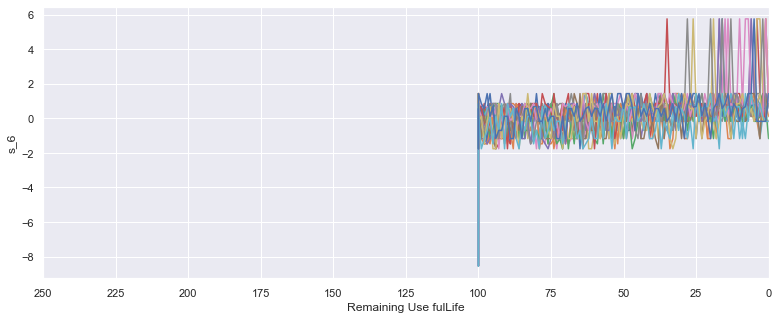

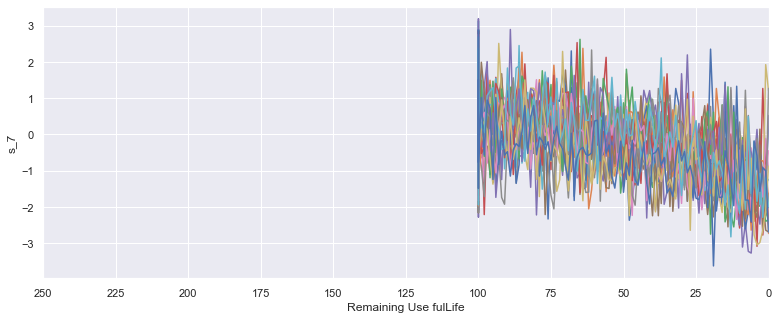

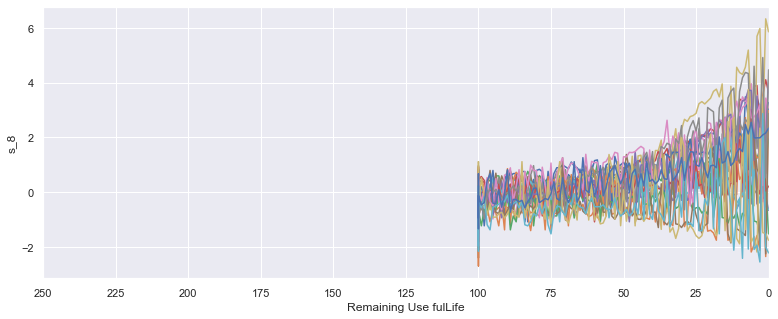

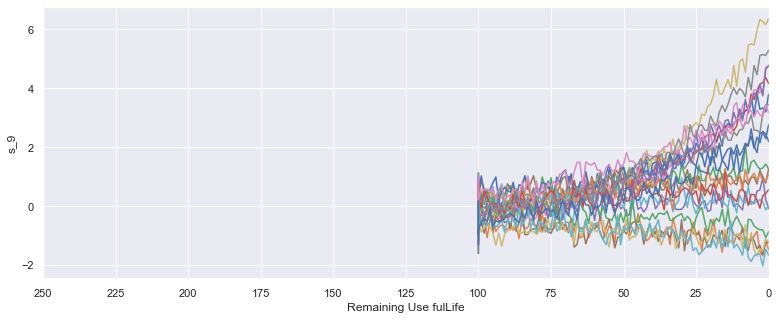

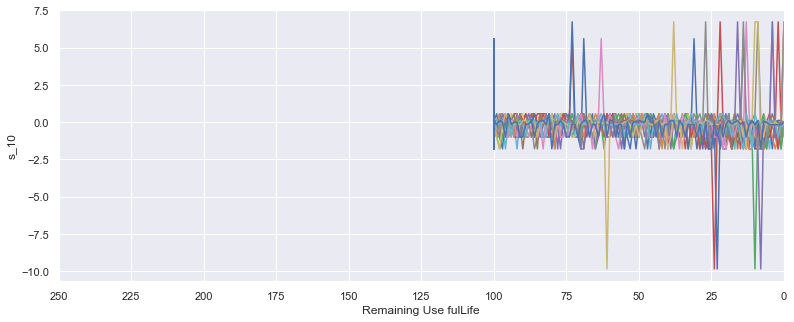

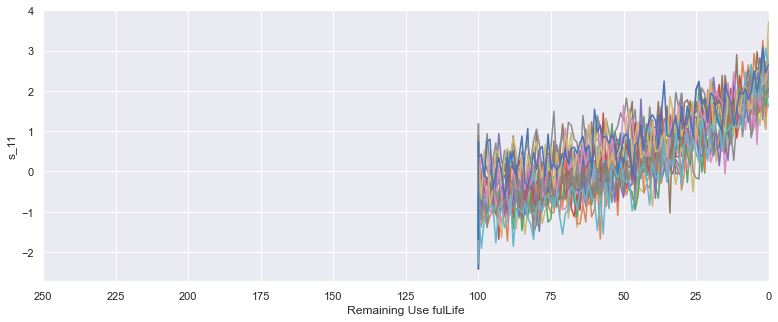

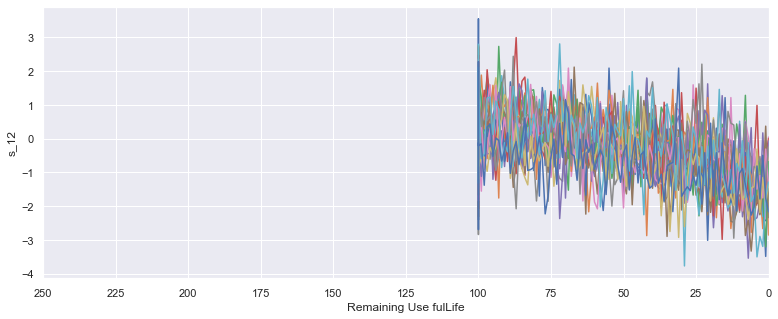

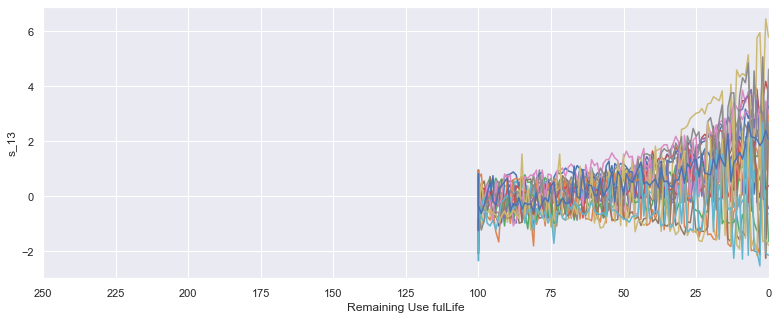

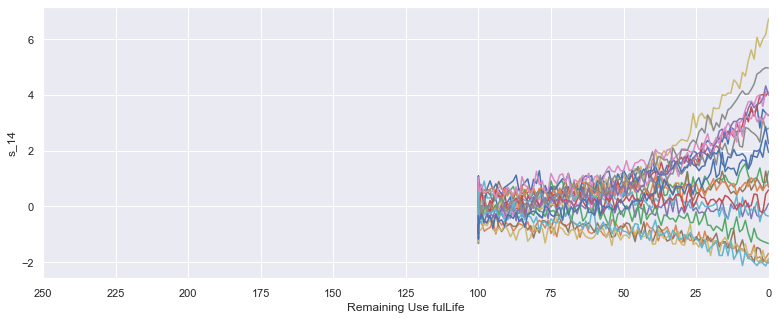

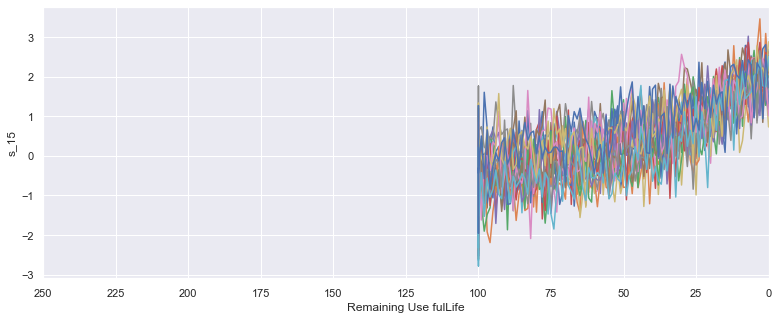

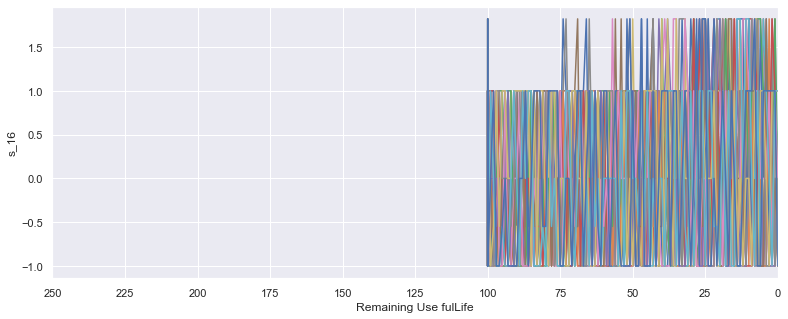

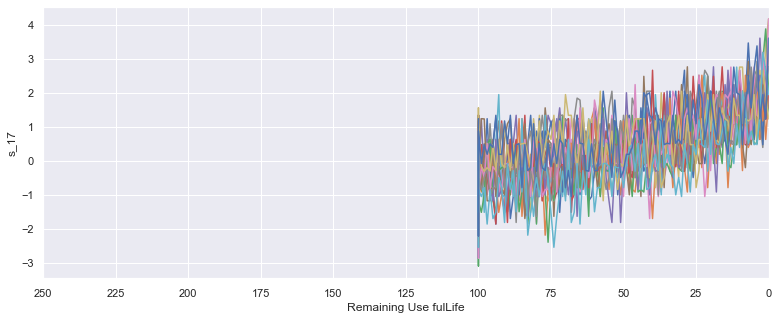

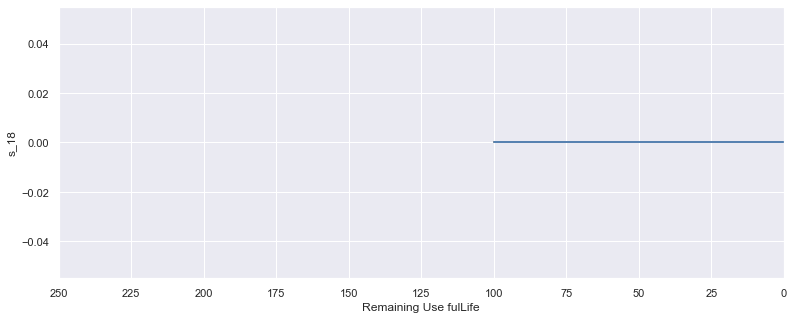

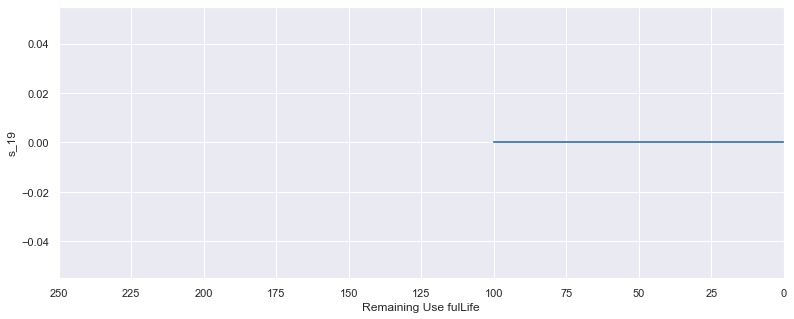

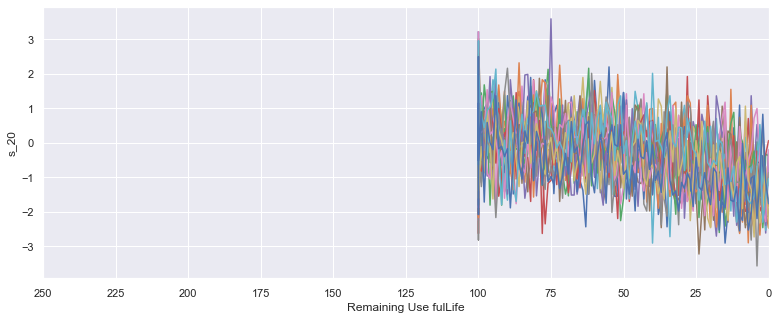

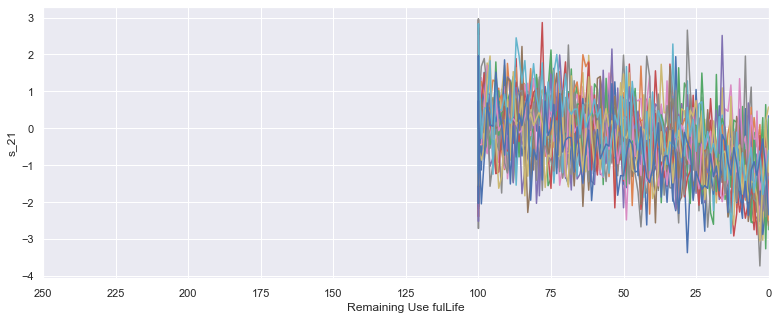

In [11]:
remaining_sensors = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
X_train_interim = create_clusters(train)
scalers = create_scalers(X_train_interim, remaining_sensors)

X_train_condition_scaled = scale(X_train_interim, scalers, remaining_sensors)
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

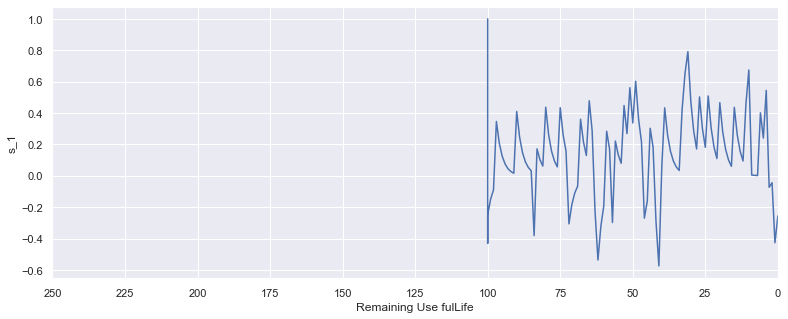

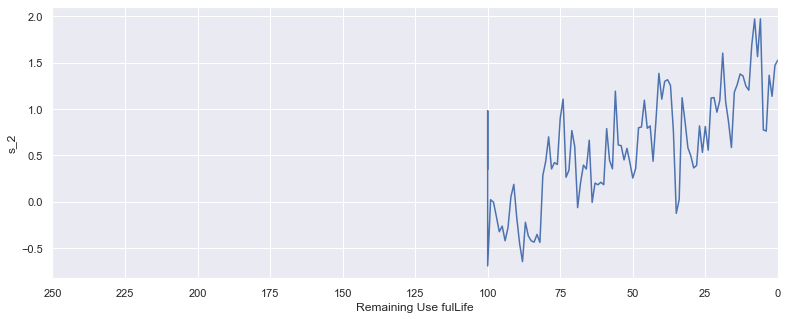

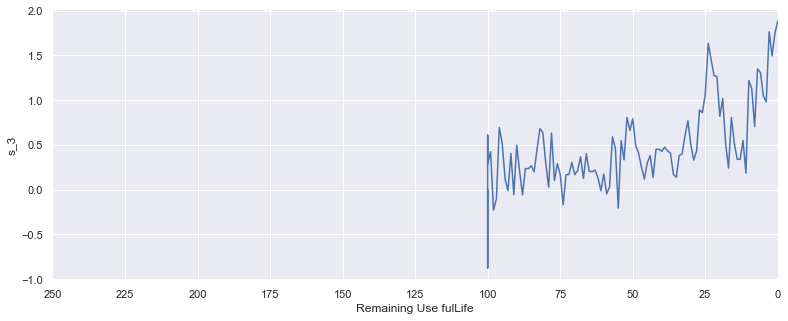

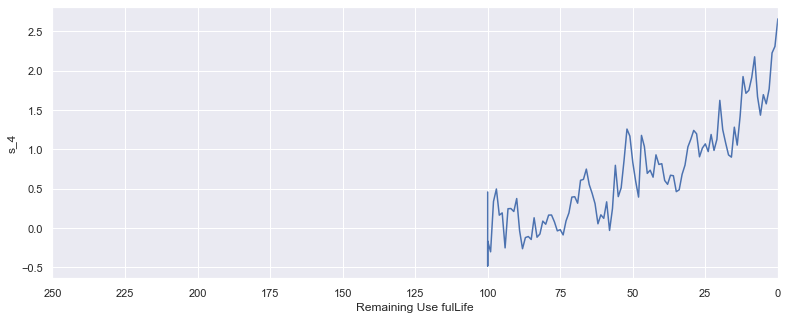

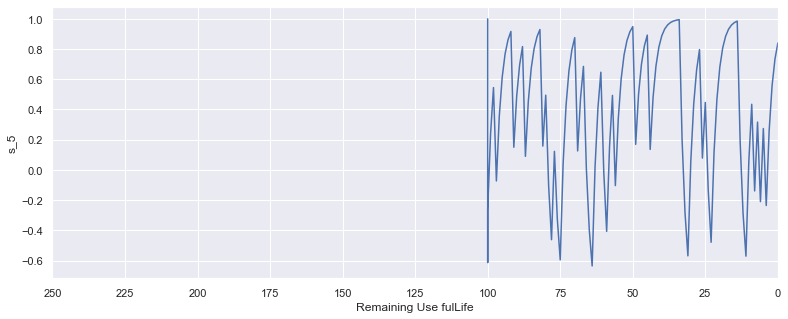

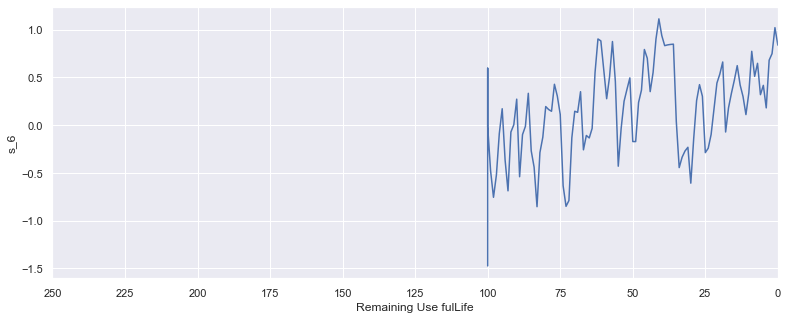

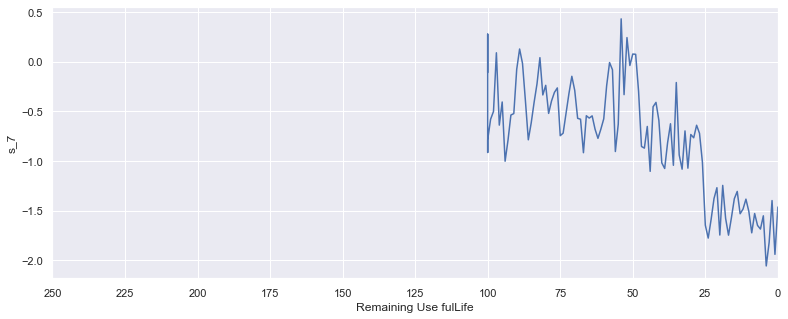

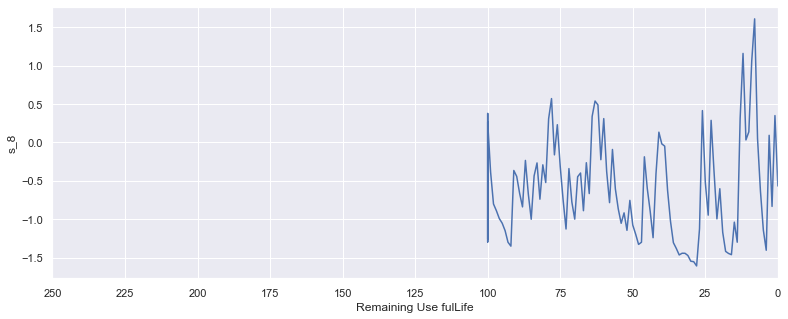

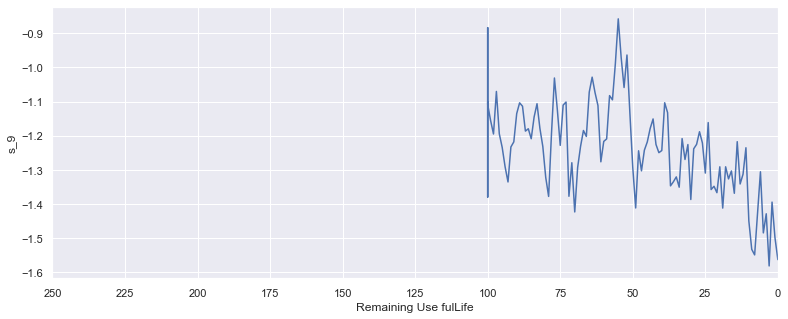

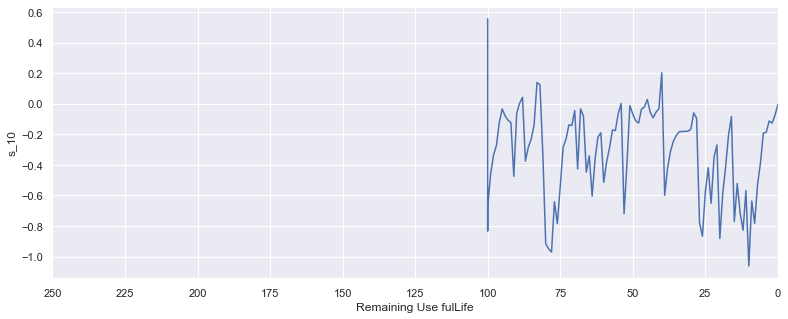

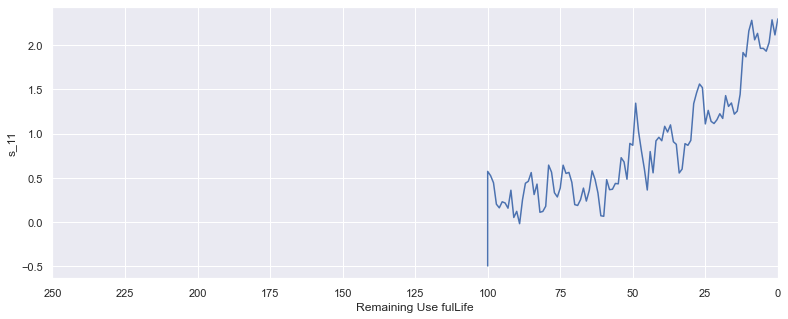

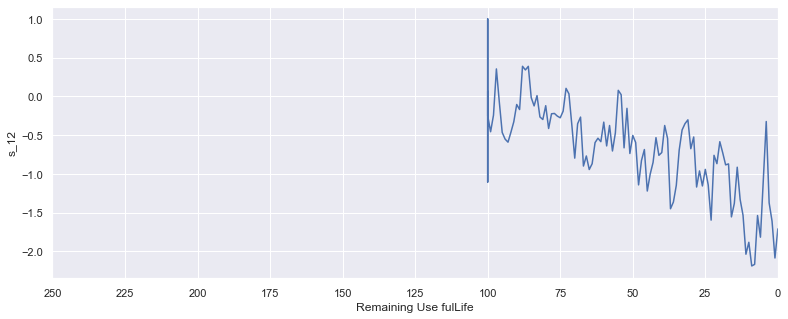

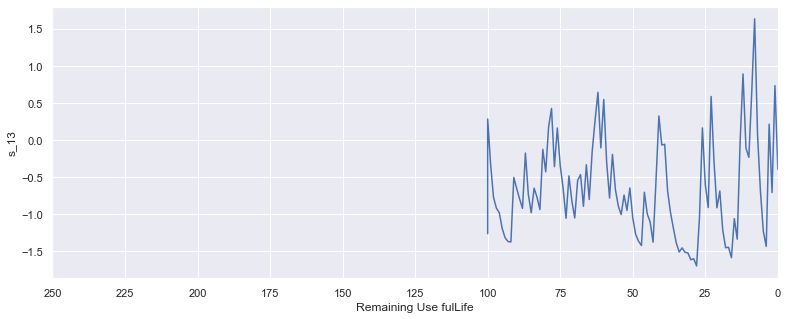

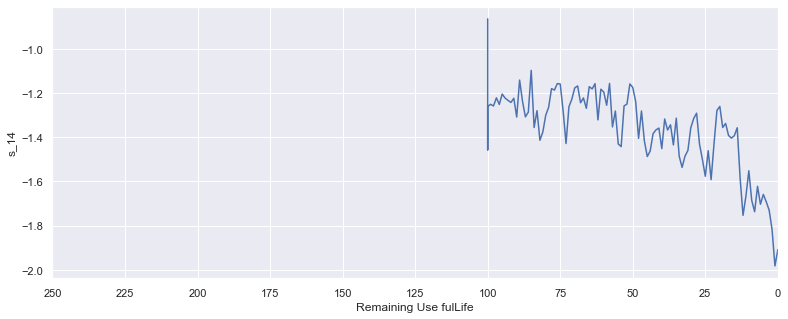

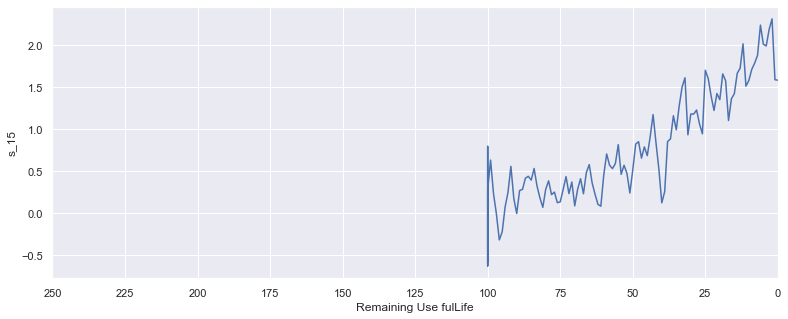

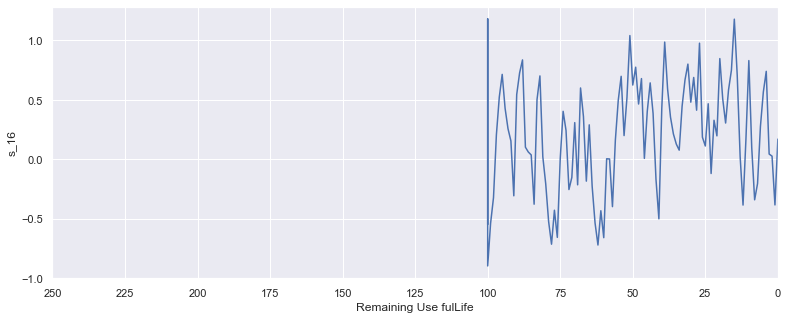

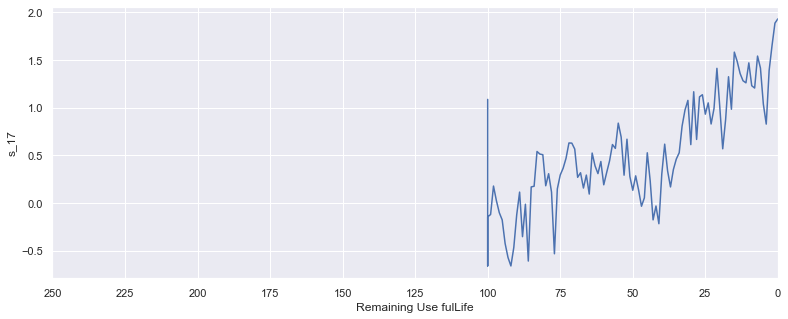

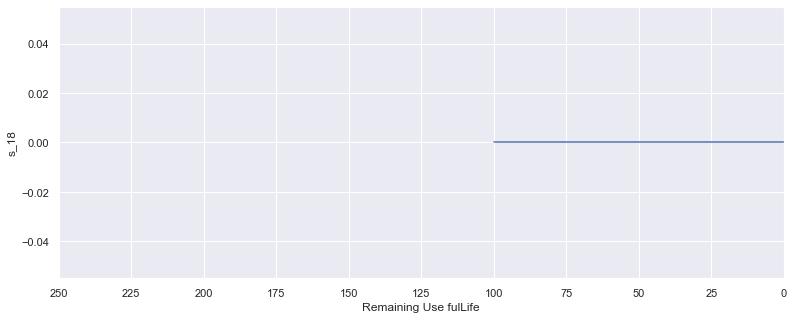

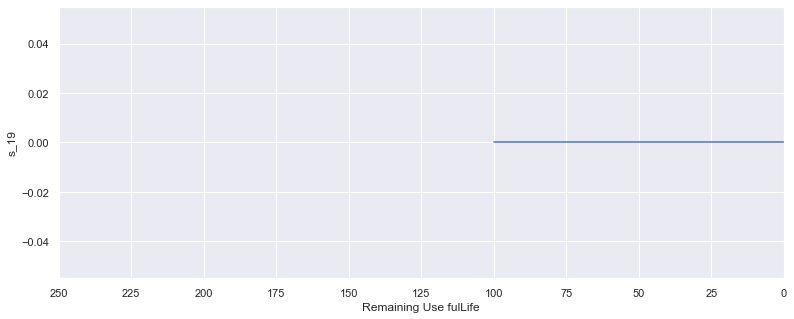

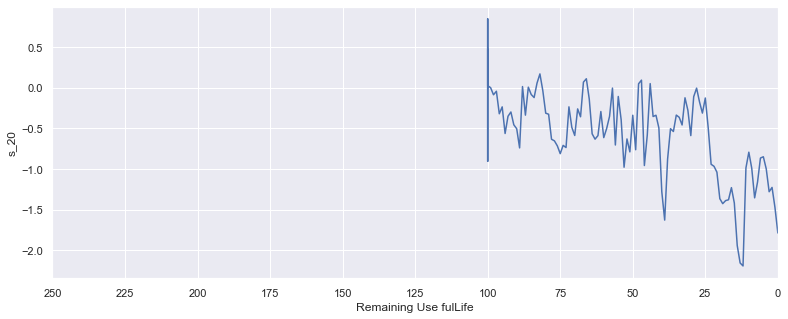

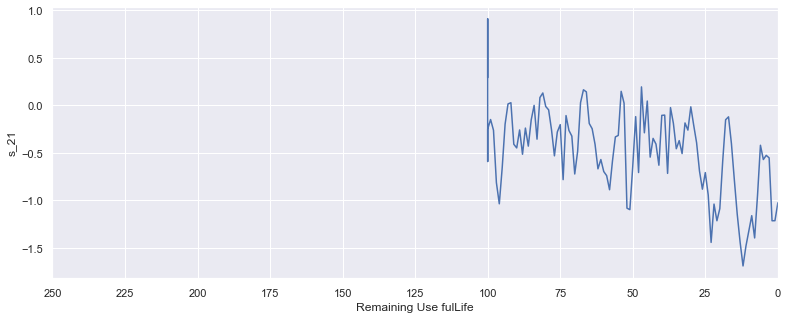

In [25]:
remaining_sensors = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
X_train_interim = create_clusters(train)
scalers = create_scalers(X_train_interim, remaining_sensors)

X_train_condition_scaled = scale(X_train_interim, scalers, remaining_sensors)
X_train_smoothed = exponential_smoothing(X_train_condition_scaled, remaining_sensors, 0, 0.4)
for sensor in sensor_names:
    plot_signal(X_train_smoothed, sensor,unit_nr=3)

## Competition Scorer

In [12]:
import math
from sklearn.metrics import make_scorer

def phm_Score_metric(y_true, y_pred):
    score = 0
    for t, p in zip(y_true, y_pred):
        if p >= t:
            score+= math.exp(-(p-t)/13) - 1
        else:
            score+= math.exp(-(p-t)/10) - 1
    return score
# # my_scorer = make_scorer(phm_Score, greater_is_better=False)

import tensorflow.keras.backend as K

def phm_Score(y_true, y_pred):
    loss = K.sum(K.switch(tf.greater_equal(y_pred, y_true), K.exp(-(y_pred-y_true)/13)-1, K.exp(-(y_pred-y_true)/10)-1))
    return loss

## Sequencer

In [13]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [14]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [15]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

## LSTM-AE

In [16]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='Test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    phm = phm_Score_metric(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, PHM:{}'.format(label, rmse, variance, phm))

In [18]:
# remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
#        's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] #s_1, s_5, s_6, s_10, s_16, s_18, s_19

In [19]:
sequence_length = 40
X_train_interim = create_clusters(train.drop(drop_sensors, axis=1))
X_test_interim = create_clusters(test.drop(drop_sensors, axis=1))

scalers = create_scalers(X_train_interim, remaining_sensors)

X_train_interim = scale(X_train_interim, scalers, remaining_sensors)
X_test_interim= scale(X_test_interim, scalers, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

In [51]:
# define encoder
visible = Input(shape=(sequence_length, train_array.shape[2]))
e = Masking(mask_value=-99.)(visible)
e = LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='encoder_1')(e)
e = LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2')(e)
e = LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3')(e)
# define bottleneck
n_bottleneck = sequence_length
bottleneck = RepeatVector(n_bottleneck, name='bottleneck')(e)
# define decoder
d = LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1')(bottleneck)
d = LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2')(d)
d = LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3')(d)
# output layer
output = TimeDistributed(Dense(train_array.shape[2]))(d)
# define autoencoder model
fe_model = Model(inputs=visible, outputs=output)
# compile autoencoder model
fe_model.compile(optimizer='adam', loss='mse')

print(fe_model.summary())



Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40, 14)]          0         
_________________________________________________________________
masking_5 (Masking)          (None, 40, 14)            0         
_________________________________________________________________
encoder_1 (LSTM)             (None, 40, 64)            20224     
_________________________________________________________________
encoder_2 (LSTM)             (None, 40, 32)            12416     
_________________________________________________________________
encoder_3 (LSTM)             (None, 16)                3136      
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 40, 16)            0         
_________________________________________________________________
decoder_1 (LSTM)             (None, 40, 16)            2112

In [52]:
ae_hist = fe_model.fit(train_split_array, train_split_array, validation_data=(val_split_array, val_split_array), epochs=10, batch_size=64, shuffle=True)

Train on 29634 samples, validate on 7782 samples
Epoch 1/15
29634/29634 [==============================] - 52s 2ms/sample - loss: 0.1318 - val_loss: 0.1119
Epoch 2/15
29634/29634 [==============================] - 38s 1ms/sample - loss: 0.1058 - val_loss: 0.1057
Epoch 3/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.1017 - val_loss: 0.1079
Epoch 4/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0997 - val_loss: 0.1015
Epoch 5/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0980 - val_loss: 0.0998
Epoch 6/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0967 - val_loss: 0.1024
Epoch 7/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0966 - val_loss: 0.0984
Epoch 8/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0953 - val_loss: 0.0997
Epoch 9/15
29634/29634 [==============================] - 37s 1ms/sample - loss: 0.0947 - val_l

In [53]:
encoder = Model(inputs=visible, outputs=bottleneck)
# plot_model(encoder, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [ ]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
#     plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(ae_hist)

## LSTM for regression after feature extraction

In [54]:
encoded_train = encoder.predict(train_split_array)
encoded_val = encoder.predict(val_split_array)

In [74]:
encoded_train.shape

(29634, 40, 16)

In [72]:
reg_model = Sequential()
reg_model.add(Masking(mask_value=-99., input_shape=(sequence_length, encoded_train.shape[2])))
reg_model.add(LSTM(128, activation='sigmoid'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(1))

reg_model.compile(optimizer='adam', loss='mse')

In [75]:
history = reg_model.fit(encoded_train, train_split_label,
                    validation_data=(encoded_val, val_split_label),
                    epochs=10,
                    batch_size=64)

Train on 29634 samples, validate on 7782 samples
Epoch 1/10
29634/29634 [==============================] - 15s 504us/sample - loss: 3269.9526 - val_loss: 1988.6881
Epoch 2/10
29634/29634 [==============================] - 13s 453us/sample - loss: 1459.4319 - val_loss: 1196.3611
Epoch 3/10
29634/29634 [==============================] - 13s 446us/sample - loss: 1141.8551 - val_loss: 1106.5851
Epoch 4/10
29634/29634 [==============================] - 13s 453us/sample - loss: 1119.1535 - val_loss: 1082.1544
Epoch 5/10
29634/29634 [==============================] - 13s 450us/sample - loss: 1067.1202 - val_loss: 914.6805
Epoch 6/10
29634/29634 [==============================] - 13s 444us/sample - loss: 414.5697 - val_loss: 184.5050
Epoch 7/10
29634/29634 [==============================] - 14s 458us/sample - loss: 182.2932 - val_loss: 119.7985
Epoch 8/10
29634/29634 [==============================] - 14s 481us/sample - loss: 149.3811 - val_loss: 108.6917
Epoch 9/10
29634/29634 [==============

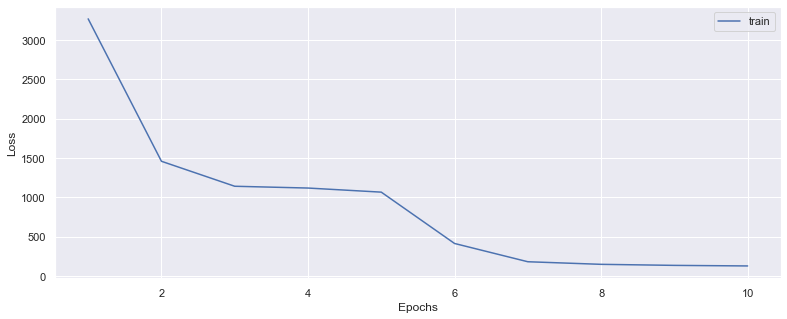

In [76]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
#     plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [80]:
# predict and evaluate
y_hat_train = reg_model.predict(encoded_train)
evaluate(train_split_label, y_hat_train, 'train')

y_hat_test = reg_model.predict(encoded_val)
evaluate(val_split_label, y_hat_test)

train set RMSE:11.483017921447754, R2:0.880942866923801, PHM:4647.662906599141
Test set RMSE:10.861266136169434, R2:0.8925811117242533, PHM:1171.0355974487018


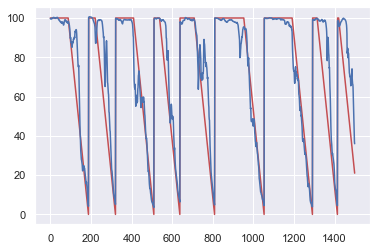

In [85]:
#new
plt.plot(val_split_label[:1500], c='r')
plt.plot(y_hat_test[:1500], c='b')
plt.savefig('./plots/test_80.jpg')
#score = 1534.72147604

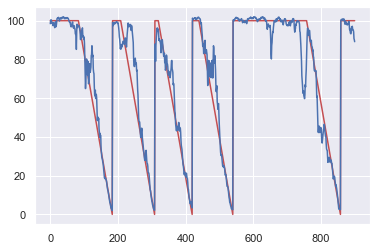

In [28]:
#new
plt.plot(label_array[:900], c='r')
plt.plot(y_hat_train[:900], c='b')
plt.savefig('./plots/test_80.jpg')

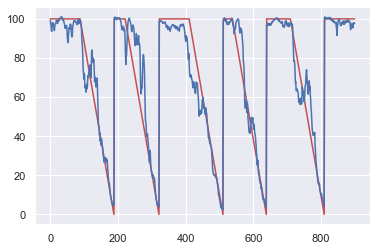

In [23]:
#new
plt.plot(val_split_label[:900], c='r')
plt.plot(y_hat_test[:900], c='b')
plt.savefig('./plots/test_80_custom_loss.jpg')

# Make submission

In [82]:
pred = reg_model.predict(encoder.predict(test_array))

In [83]:
with open("sub__10.txt", 'w') as output:
    for row in [p[0] for p in pred]:
        output.write(str(row) + '\n')